In [6]:
# Importing necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Load the dataset
housing_survey_df = pd.read_csv('HousingSurvey1.csv')

# Inspect the first few rows to understand the structure and initial data
housing_survey_df.head()

# Get an overview of the dataset, including data types, null counts, and memory usage
# This step helps us identify missing values, types of data, and columns that might need cleaning
housing_survey_df.info()

# Summary statistics of the numerical columns in the dataset (e.g., mean, std, min, max)
# This gives an understanding of the numerical distributions and potential outliers
housing_survey_df.describe()

# Step 1: Data Cleaning

# Remove rows where all answers are missing
# This ensures that incomplete or irrelevant rows are excluded from the analysis
housing_survey_cleaned = housing_survey_df.dropna(how='all')

# Remove rows where students are not from Purdue ('Purdue student?' column has 'No')
# We only want to focus on Purdue students in this analysis
housing_survey_cleaned = housing_survey_cleaned[housing_survey_cleaned['Purdue student?'] != 'No']

# Drop irrelevant columns that won't contribute to clustering
# These columns are metadata (such as start/end date, IP address) that do not influence student preferences
housing_survey_cleaned = housing_survey_cleaned.drop(columns=[
    'StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
    'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
    'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
    'ExternalReference', 'DistributionChannel', 'UserLanguage'
])




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   StartDate                                  67 non-null     object 
 1   EndDate                                    67 non-null     object 
 2   Status                                     67 non-null     object 
 3   IPAddress                                  51 non-null     object 
 4   Progress                                   67 non-null     int64  
 5   Duration (in seconds)                      67 non-null     int64  
 6   Finished                                   67 non-null     bool   
 7   RecordedDate                               67 non-null     object 
 8   ResponseId                                 67 non-null     object 
 9   RecipientLastName                          0 non-null      float64
 10  RecipientFirstName          

In [7]:
# Step 2: Handling Missing Values

# Identify which columns are numerical and which are categorical for imputation
# Numerical columns will use median imputation; categorical columns will use mode imputation
numeric_cols = housing_survey_cleaned.select_dtypes(include=[np.number]).columns
categorical_cols = housing_survey_cleaned.select_dtypes(include=['object']).columns

# Impute missing values in numerical columns using the median
# The median is a robust measure of central tendency that reduces the effect of outliers
imputer_num = SimpleImputer(strategy='median')

# Identify columns where all values are NaN and exclude them from further processing
nan_cols = housing_survey_cleaned[numeric_cols].columns[housing_survey_cleaned[numeric_cols].isna().all()]
numeric_cols = numeric_cols.drop(nan_cols)  # Dropping completely empty numerical columns

# Apply median imputation to the remaining numeric columns to fill in missing values
housing_survey_cleaned[numeric_cols] = imputer_num.fit_transform(housing_survey_cleaned[numeric_cols])

# Impute missing values in categorical columns using the mode (most frequent value)
# The mode is appropriate for categorical data since it represents the most common value
imputer_cat = SimpleImputer(strategy='most_frequent')
housing_survey_cleaned[categorical_cols] = imputer_cat.fit_transform(housing_survey_cleaned[categorical_cols])



In [8]:
# Step 3: Data Preprocessing

# Convert categorical variables into numerical format using one-hot encoding
# This allows categorical variables (e.g., Gender, Program) to be used in machine learning algorithms like K-Means
# drop_first=True removes one dummy variable to avoid multicollinearity
housing_survey_encoded = pd.get_dummies(housing_survey_cleaned, drop_first=True)

# Standardize the data using StandardScaler to ensure all features contribute equally to the clustering process
# Standardization ensures that variables with different scales (e.g., rent vs age) are treated equally in the model
scaler = StandardScaler()
housing_survey_scaled = scaler.fit_transform(housing_survey_encoded)




/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Descriptive statistics for numerical features:
       LocationLatitude  LocationLongitude  Q_RecaptchaScore  \
count         60.000000          60.000000         60.000000   
mean          40.713645         -83.097943          0.968333   
std            2.195369          21.203836          0.092958   
min           33.447500        -121.919100          0.400000   
25%           40.444400         -86.925600          1.000000   
50%           40.444400         -86.925600          1.000000   
75%           40.444400         -86.925600          1.000000   
max           48.951200           2.338700          1.000000   

       Preference_Private_Bathroom  
count                    60.000000  
mean                      4.350000  
std                       0.898681  
min                       2.000000  
25%                       4.000000  
50%                       5.000000  
75%                       5.000000  
max                       5.000000  

Descriptive Statistics for Categorical Var

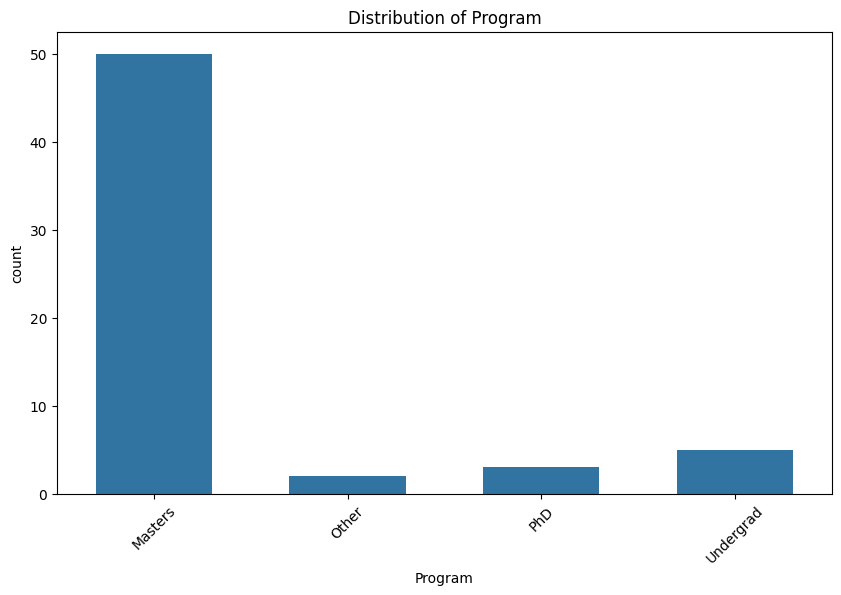

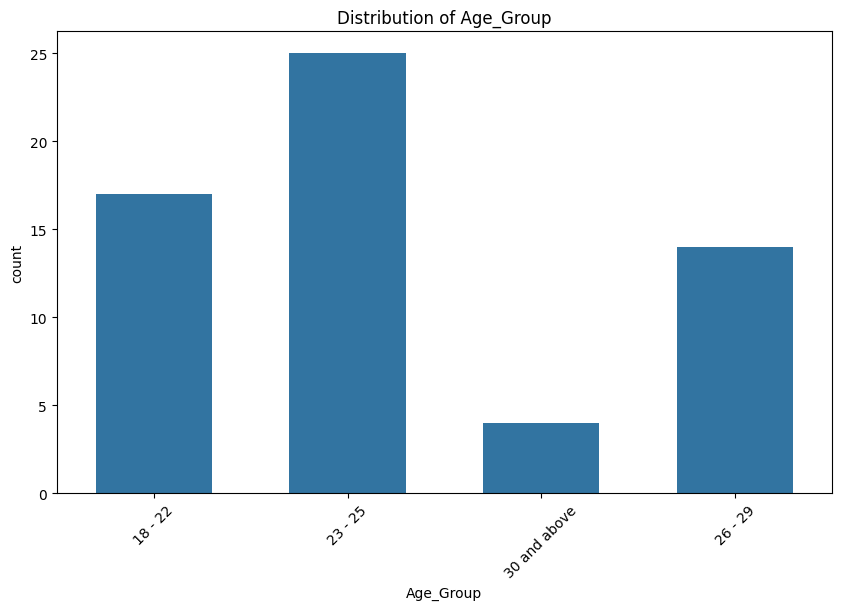

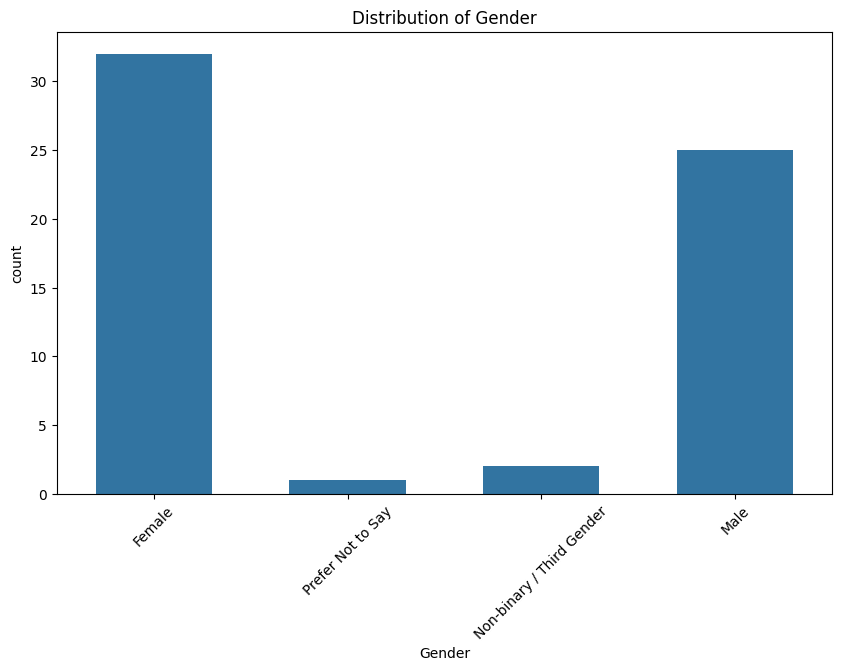

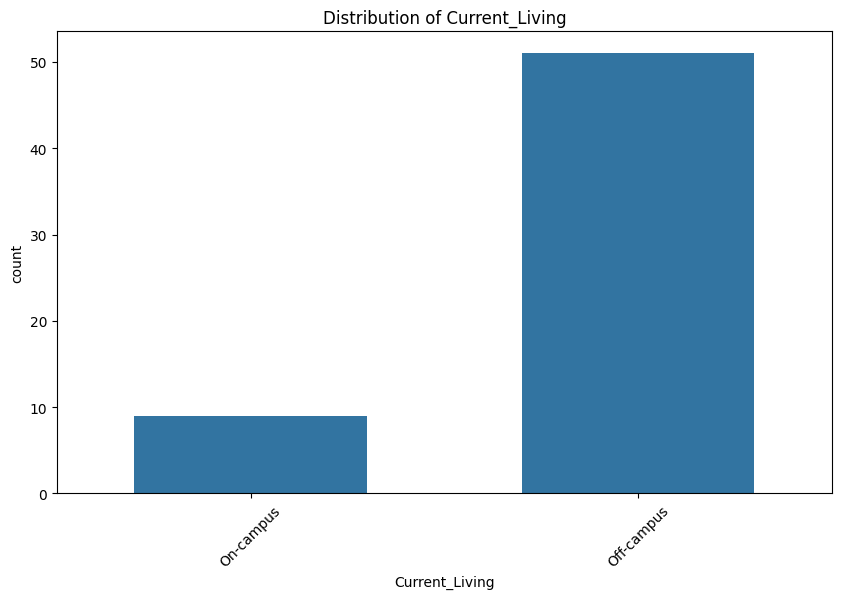

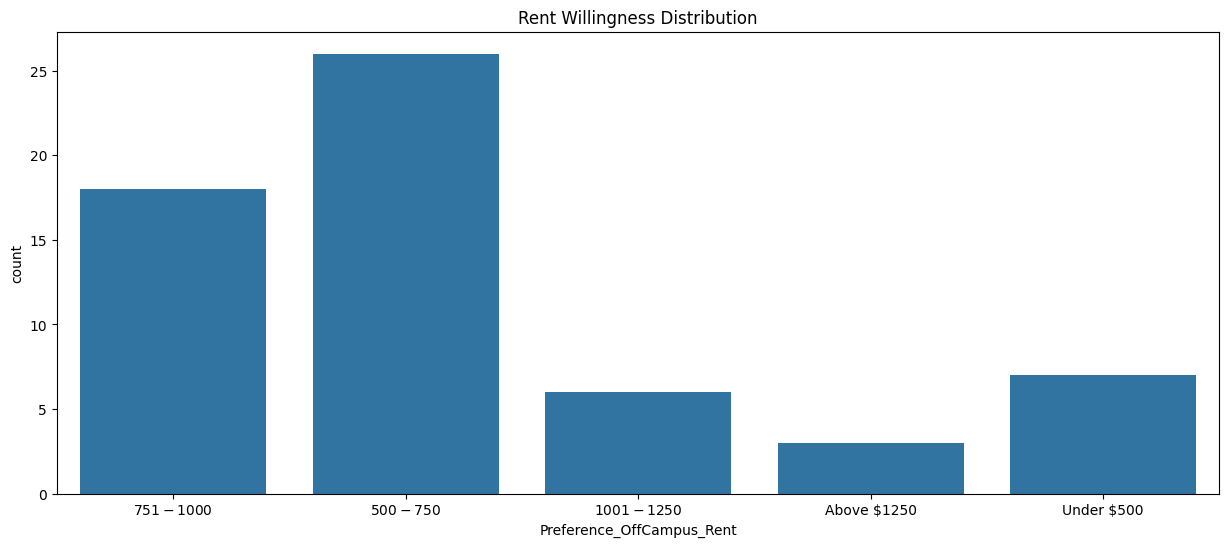

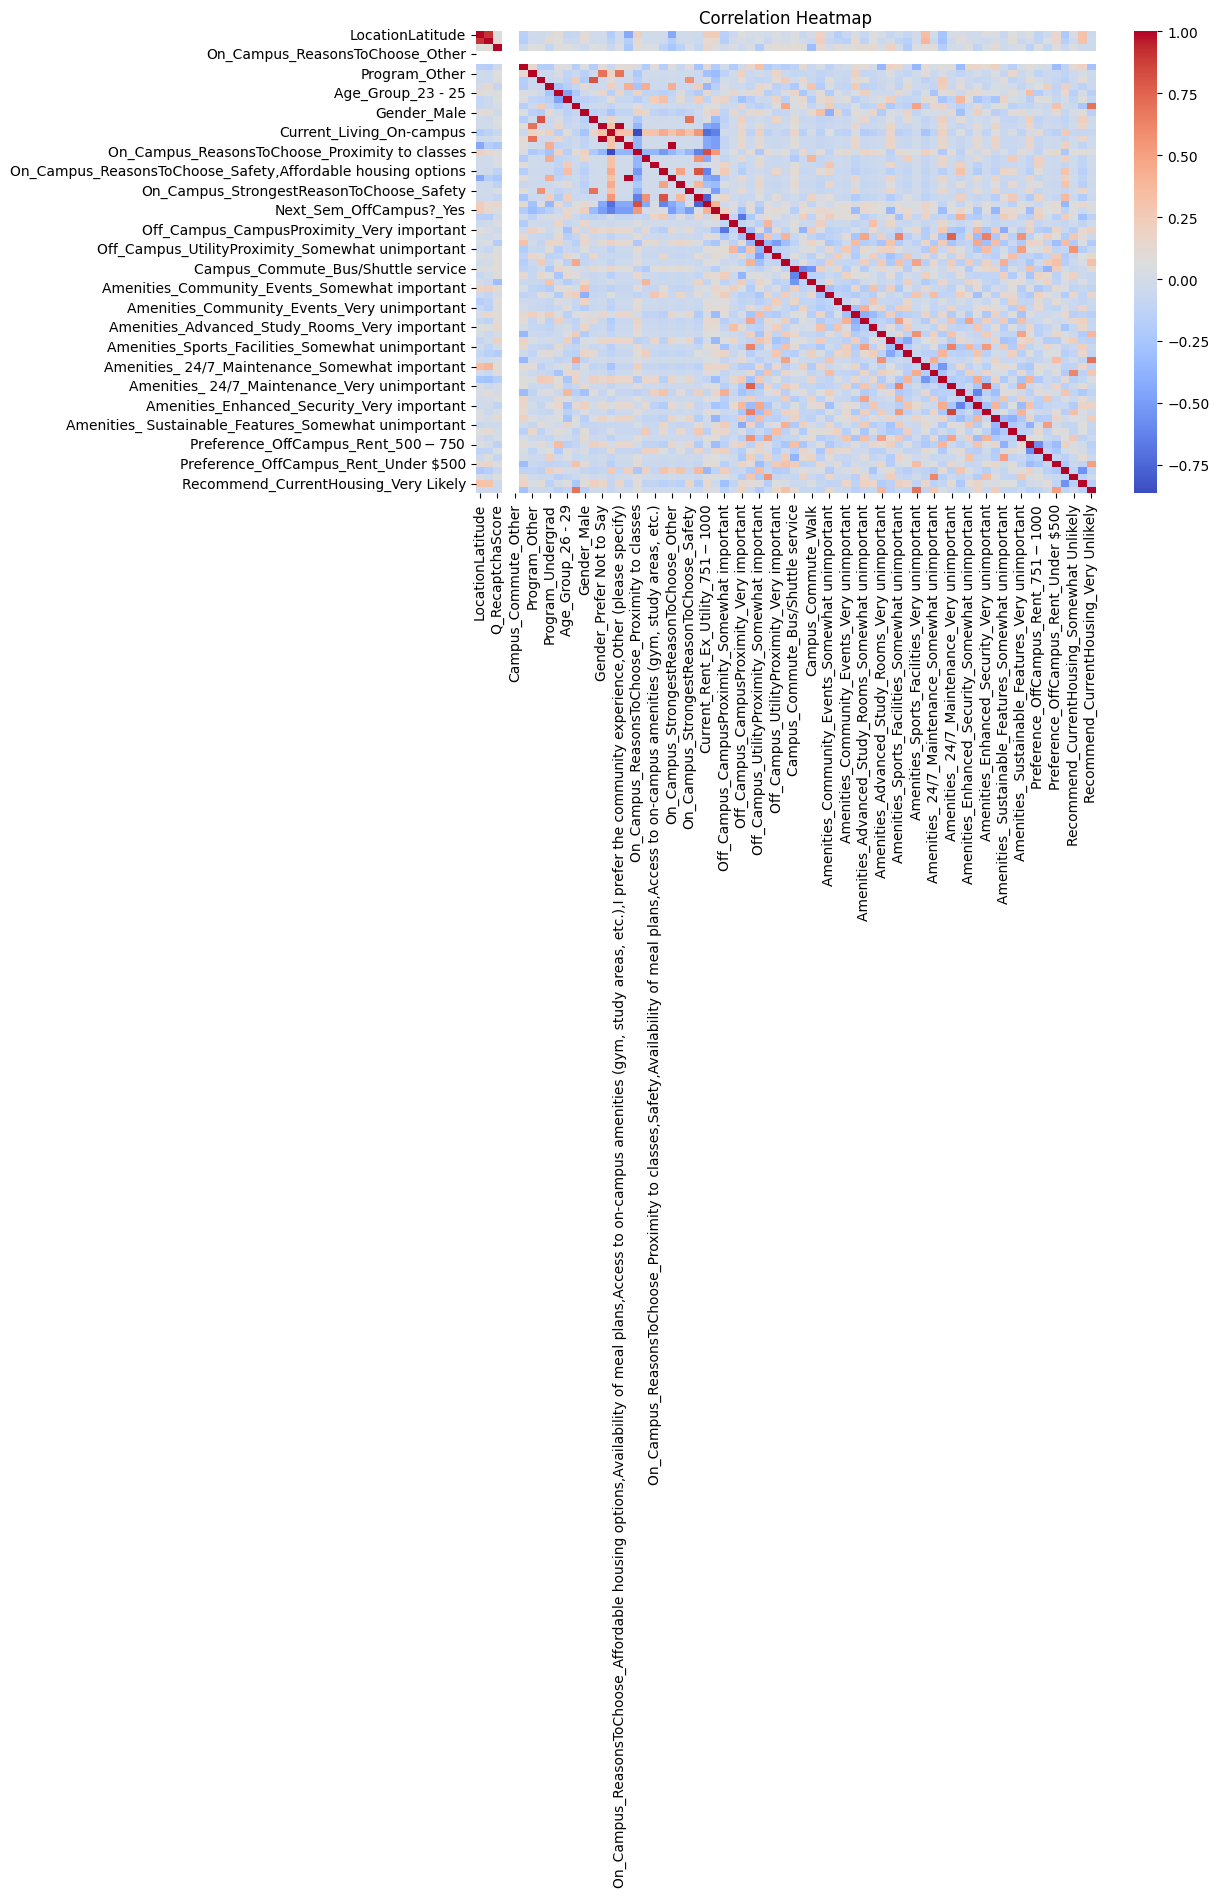

In [9]:
# Step 4: Descriptive Statistics and Visualizations

# Calculate and display summary statistics for numerical columns
# This helps us understand the range, central tendencies, and variability of the numerical features in the dataset
print("Descriptive statistics for numerical features:")
print(housing_survey_cleaned[numeric_cols].describe())

# List of categorical columns for further analysis and visualization
categorical_columns_to_analyze = ['Program', 'Age_Group', 'Gender', 'Current_Living']

# For each categorical column, print the frequency counts (how many times each category appears in the data)
# This provides insights into the distribution of categories in the dataset (e.g., how many students belong to each age group)
print("\nDescriptive Statistics for Categorical Variables:")
for column in categorical_columns_to_analyze:
    print(f"\n{column} value counts:")
    print(housing_survey_cleaned[column].value_counts())

# Visualizing the distribution of each categorical variable using bar plots
# Bar plots help us see the distribution of categories (e.g., gender distribution, housing choices)
for column in categorical_columns_to_analyze:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=housing_survey_cleaned[column], width=0.6)  # Bar width reduced for clarity
    plt.title(f"Distribution of {column}")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

# Visualize rent willingness (how much rent students are willing to pay for off-campus housing)
plt.figure(figsize=(15, 6))
sns.countplot(x=housing_survey_cleaned['Preference_OffCampus_Rent'])
plt.title('Rent Willingness Distribution')
plt.show()

# Correlation heatmap to show relationships between all numerical and encoded categorical variables
# This helps us understand how features are related to each other (e.g., whether rent willingness is correlated with proximity to campus)
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(housing_survey_scaled, columns=housing_survey_encoded.columns).corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()



NaN values in scaled data before clustering: 120
NaN values in scaled data after cleaning: 0


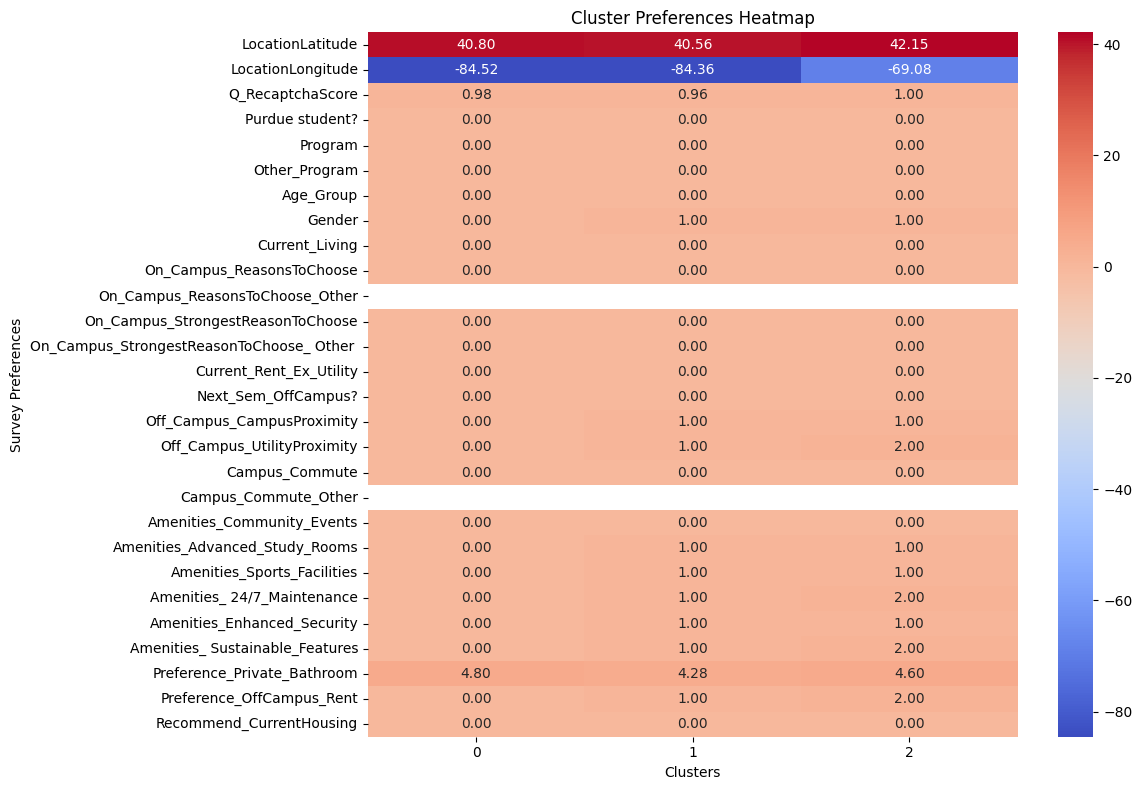

In [10]:
# Step 5: Clustering (Model Building)

# Apply K-Means clustering to divide students into 3 clusters based on their preferences
# K-Means attempts to minimize the variance within each cluster by assigning students with similar preferences to the same cluster

# Check for any NaN values in the scaled data before applying K-Means clustering
print("NaN values in scaled data before clustering:", np.isnan(housing_survey_scaled).sum())

# Fill NaN or infinite values in the scaled data
# np.nan_to_num replaces NaNs with 0 and infinite values with the largest/smallest possible float values
housing_survey_scaled = np.nan_to_num(housing_survey_scaled, nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)

# Check again to confirm there are no NaN values after cleaning
print("NaN values in scaled data after cleaning:", np.isnan(housing_survey_scaled).sum())

# Applying K-Means clustering with 3 clusters
# We are using 3 clusters based on prior exploratory analysis (e.g., Elbow Method or Silhouette Score)
kmeans = KMeans(n_clusters=3, random_state=42)
housing_survey_cleaned['Cluster'] = kmeans.fit_predict(housing_survey_scaled)  # Assign each student to a cluster

# Analyzing the clusters
# Grouping the data by the 'Cluster' column to calculate the mean (for numeric variables) and mode (for categorical variables)
cluster_analysis = housing_survey_cleaned.groupby('Cluster').agg(
    lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.value_counts().index[0]  # Use mode for categorical variables
)

# Convert categorical columns in cluster_analysis to numerical for better visualization in heatmaps
for col in cluster_analysis.columns:
    if not pd.api.types.is_numeric_dtype(cluster_analysis[col]):
        cluster_analysis[col] = pd.factorize(cluster_analysis[col])[0]

# Visualizing the preferences of each cluster using a heatmap
# This heatmap will highlight differences in preferences between clusters (e.g., rent willingness, amenity preferences)
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_analysis.T, cmap="coolwarm", annot=True, fmt=".2f")  # Format to show two decimal places
plt.title("Cluster Preferences Heatmap")
plt.xlabel("Clusters")
plt.ylabel("Survey Preferences")
plt.tight_layout()
plt.show()



In [11]:
# Step 6: Insights

# Summarize insights for each cluster by displaying the most important preferences and characteristics
# For example, which cluster values premium amenities or lower rent more
for cluster in range(3):
    print(f"Cluster {cluster}:")
    print(cluster_analysis.loc[cluster])
    print("\n")



Cluster 0:
LocationLatitude                             40.80058
LocationLongitude                           -84.51746
Q_RecaptchaScore                              0.98000
Purdue student?                               0.00000
Program                                       0.00000
Other_Program                                 0.00000
Age_Group                                     0.00000
Gender                                        0.00000
Current_Living                                0.00000
On_Campus_ReasonsToChoose                     0.00000
On_Campus_ReasonsToChoose_Other                   NaN
On_Campus_StrongestReasonToChoose             0.00000
On_Campus_StrongestReasonToChoose_ Other      0.00000
Current_Rent_Ex_Utility                       0.00000
Next_Sem_OffCampus?                           0.00000
Off_Campus_CampusProximity                    0.00000
Off_Campus_UtilityProximity                   0.00000
Campus_Commute                                0.00000
Campus_Commute_Ot

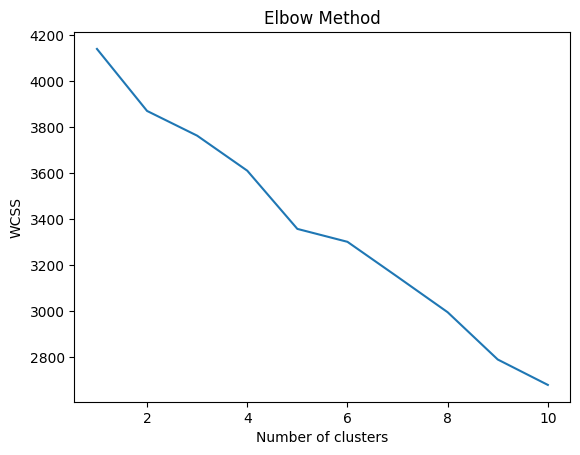

In [14]:

# Determine the optimal number of clusters using Elbow method

# Initialize a list to store the WCSS (Within-Cluster Sum of Squares) for each number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(housing_survey_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the elbow method graph to visualize the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()